In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
%matplotlib notebook

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import pydensecrf.densecrf as dcrf
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import logging
import yaml
import json
from PIL import Image as pil_image
from osgeo import gdal, ogr, osr

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from NeMO_models import FCN
from NeMO_losses import charbonnierLoss
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/RefineMask_Jarrett512_May3D.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D, 'charbonnierLoss': charbonnierLoss})

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<IPython.core.display.Javascript object>


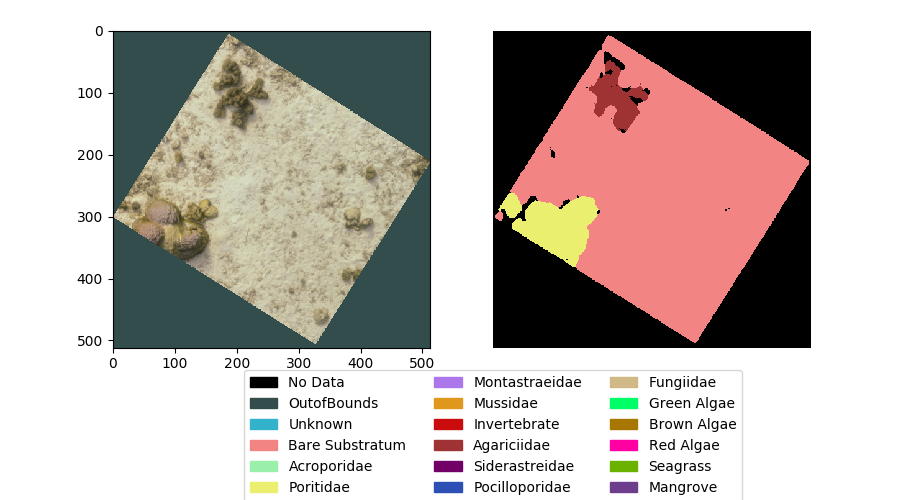

In [19]:
# imgpath = '../Images/AppData_May'
# file = "LargeGuamOrthomosaic_1.jpg" # Large transect 
imgpath = '../Images/AppData_Training/TrainImages/No Data'
truthpath_gray = '../Images/AppData_Training/LabelImages/No Data'
file = "Coral_00000006.png"


coralcolors_dict = { "No Data": "#000000",
               "OutofBounds": "#334C4C",
               "Unknown": "#33B2CC",
               "Bare Substratum": "#F38484",
               "Acroporidae": "#9AEFAB",
               "Poritidae": "#EAEF70",
               "Gorgoniidae": "#F885EB",
               "Merulinidae": "#85F7F8",
               "Montastraeidae": "#AD77EC",
               "Mussidae": "#DF981C",
               "Invertebrate": "#CB0C0C",
               "Agariciidae": "#9F3333",
               "Siderastreidae": "#710067",
               "Pocilloporidae": "#2C50B4",
               "Alcyoniidae": "#7EA4AC",
               "Fungiidae": "#D0B987",
               "Green Algae": "#00FF66",
               "Brown Algae": "#A87700",
               "Red Algae": "#FF00A2",
               "Seagrass": "#69B300",
               "Mangrove": "#6d3E8E",
               "Plexauridae": "#FF8400"}

cmap = [coralcolors_dict[k] for k in coralcolors_dict.keys()]
cmap = colors.ListedColormap(cmap)
bounds = [i-0.5 for i in range(cmap.N + 1)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

labelkey = [np.uint8(255/cmap.N*i) for i in range(cmap.N)] # Assuming labels are saved according to # of consolclass

img = cv2.cvtColor(cv2.imread(os.path.join(imgpath,file), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
img_truthgray = np.asarray(cv2.imread(os.path.join(truthpath_gray,file), cv2.IMREAD_GRAYSCALE), dtype=np.uint8)

item_counter = 0
for item in labelkey:
    y,x = np.where(img_truthgray == item)
    img_truthgray[y,x] = item_counter
    item_counter += 1

fig = plt.figure(figsize=(9,5))
ax = plt.subplot(1,2,1)
ax.imshow(img)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])

ax = plt.subplot(1,2,2)
ax.imshow(img_truthgray.astype(int), interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(len(cmap.colors))],
           ['{}'.format(list(coralcolors_dict.keys())[i]) for i in range(len(coralcolors_dict))],
          loc='upper center', bbox_to_anchor=(0.0,-0.05), ncol=3)
ax.set_axis_off()
plt.show()

# print(np.unique(img_classgray))
# print(np.unique(img_truthgray))

In [20]:
def classifyback(predictions):
    return np.argmax(predictions,-1)

mean = 127.5
std = 127.5
imgsize = 512

img_predict = np.zeros((img.shape[0], img.shape[1], 4))
num_predict = np.zeros((img.shape[0], img.shape[1], 4))

for ystart in range(0, img.shape[0]-int(imgsize/2), int(imgsize/2)):
    for xstart in range(0, img.shape[1]-int(imgsize/2), int(imgsize/2)):
        yy = ystart
        xx = xstart
        
        img_batch = np.expand_dims(1/std * (np.copy(img[yy:yy+imgsize, xx:xx+imgsize, :]) - mean), axis=0)
        temp_predict = model.predict(img_batch, batch_size=1)[0]
        
        if ((yy % imgsize == 0) and (xx % imgsize == 0)): # normal tiling
            img_predict[yy:yy+imgsize, xx:xx+imgsize, 0] = np.reshape(classifyback(temp_predict), (imgsize, imgsize))
            num_predict[yy:yy+imgsize, xx:xx+imgsize, 0] = 1
        elif ((yy % imgsize != 0) and (xx % imgsize == 0)): # offset tiling in y
            img_predict[yy:yy+imgsize, xx:xx+imgsize, 1] = np.reshape(classifyback(temp_predict), (imgsize, imgsize))
            num_predict[yy:yy+imgsize, xx:xx+imgsize, 1] = 1
        elif ((yy % imgsize == 0) and (xx % imgsize != 0)): # offset tiling in x
            img_predict[yy:yy+imgsize, xx:xx+imgsize, 2] = np.reshape(classifyback(temp_predict), (imgsize, imgsize))
            num_predict[yy:yy+imgsize, xx:xx+imgsize, 2] = 1
        else: # offset tiling on both
            img_predict[yy:yy+imgsize, xx:xx+imgsize, 3] = np.reshape(classifyback(temp_predict), (imgsize, imgsize))
            num_predict[yy:yy+imgsize, xx:xx+imgsize, 3] = 1

<IPython.core.display.Javascript object>


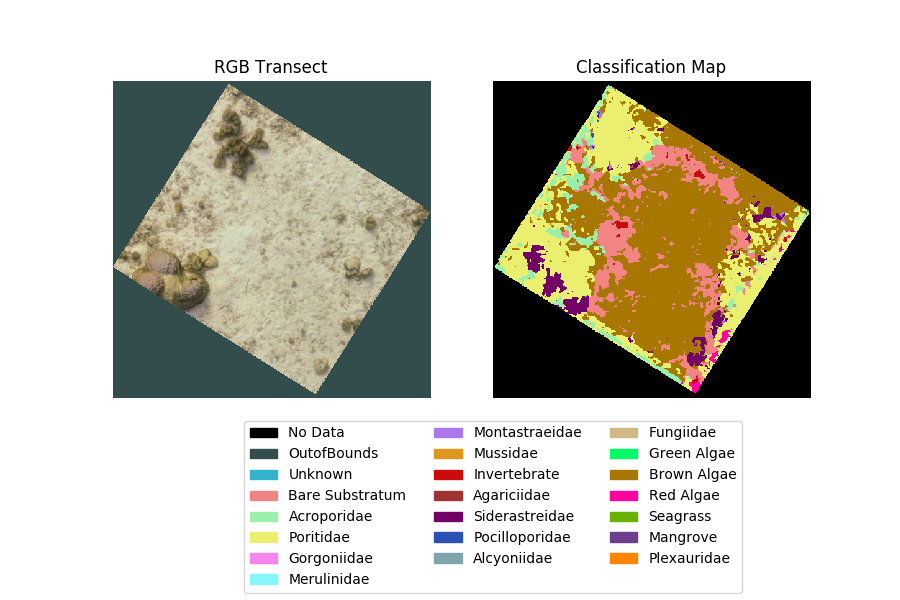

In [21]:
img_predict_final = np.zeros((img.shape[0], img.shape[1]))
for ystart in range(0, img.shape[0]):
    for xstart in range(0, img.shape[1]):
        if img_truthgray[ystart,xstart] != 1:      
            clsfied = num_predict[ystart,xstart,:] == 1
            elmt = np.bincount(img_predict[ystart,xstart,clsfied].astype(int)).argmax()
            img_predict_final[ystart,xstart] = elmt
        
img_filter = np.ones((img.shape[0], img.shape[1]))
y,x = np.where(np.all(img == np.asarray([0,0,0], dtype=np.uint8), axis=-1))
img_filter[y,x] = 0
img_predict_final = img_predict_final*img_filter

fig = plt.figure(figsize=(9,6))
ax = plt.subplot(1,2,1)
ax.imshow(img)
ax.set_axis_off()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.set_title('RGB Transect')

ax = plt.subplot(1,2,2)
ax.imshow((img_predict_final).astype(int), interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(len(cmap.colors))],
           ['{}'.format(list(coralcolors_dict.keys())[i]) for i in range(len(coralcolors_dict))],
          loc='upper center', bbox_to_anchor=(0.0,-0.05), ncol=3)
ax.set_title('Classification Map')
ax.set_axis_off()

In [5]:
# Test sliding window on species richness vs evenness
import pandas as pd

window_size = 1024

unq, unq_counts = np.unique(img_predict_final, return_counts=True)
print(unq, unq_counts)

img_richness = np.zeros((img_predict_final.shape[0]-window_size+1, img_predict_final.shape[1]-window_size+1))
img_shannon = np.zeros((img_predict_final.shape[0]-window_size+1, img_predict_final.shape[1]-window_size+1))
img_simpson = np.zeros((img_predict_final.shape[0]-window_size+1, img_predict_final.shape[1]-window_size+1))

for j in range(img_predict_final.shape[1] - window_size + 1):
    if j%100 == 0:
        print(j)
    for i in range(img_predict_final.shape[1] - window_size + 1):
        if i == 0 and j == 0:
            first_img = img_predict_final[j:j+window_size, i:i+window_size]
            n_start = np.asarray([np.sum(first_img == u) for u in unq])
            n = n_start
        elif i == 0:
            row_prev = img_predict_final[j, i:i+window_size]
            row_next = img_predict_final[j+window_size-1, i:i+window_size]
            n_prev = np.asarray([np.sum(row_prev == u) for u in unq])
            n_next = np.asarray([np.sum(row_next == u) for u in unq])
            n_start = n_start + n_next - n_prev
            n = n_start
        else:
            col_prev = img_predict_final[j:j+window_size, i]
            col_next = img_predict_final[j:j+window_size, i+window_size-1]
            n_prev = np.asarray([np.sum(col_prev == u) for u in unq])
            n_next = np.asarray([np.sum(col_next == u) for u in unq])
            n = n + n_next - n_prev

        new_n = n[1:] # gets rid of first element, which is no data
        new_n = new_n[new_n > 0]
        total = np.sum(new_n)
        p = 1/total * new_n
        img_richness[j,i] = len(new_n)
        
        if img_richness[j,i] > 0:
            img_shannon[j,i] = -np.sum(p*np.log(p))
            if img_richness[j,i] == 1:
                img_simpson[j,i] = 0
            else:
                img_simpson[j,i] = 1 - np.sum(1/(total*(total-1))*new_n*(new_n-1))
        else:
            img_shannon[j, i] = 0
            img_simpson[j, i] = 0

[ 0.  3.  4.  5.  8. 10. 12. 17. 19. 20.] [8738948 5263856    1018 2677682    4855   29582    4304     301   56205
     465]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000


In [83]:
# spectral variation window (takes way too long to calculate)
img_spectral = np.zeros((img_predict_final.shape[0]-window_size+1, img_predict_final.shape[1]-window_size+1))
img_mean = np.zeros((img_predict_final.shape[0]-window_size+1, img_predict_final.shape[1]-window_size+1, 3))
# masked_img = np.ma.masked_equal(img, [0,0,0])
# print(masked_img.shape)
# print(np.mean(masked_img[0:1024, 0:1024, :], axis=(0,1)))

# a = scipy.signal.convolve2d(masked_img[:,:,0], np.ones((1024,1024)), mode='valid')
# print()

for j in range(2):
    print(j)
    for i in range(1):
#         img_predict_final.shape[1] - window_size + 1
        if i == 0 and j == 0:
            first_img = img[j:j+window_size, i:i+window_size,:].astype(np.float64)
            first_class = img_predict_final[j:j+window_size, i:i+window_size]
            n = np.sum(first_class > 0)
            
            first_img = first_img[first_class > 0]
            mean = np.mean(first_img, axis=0)
            img_mean[j,i,:] = mean
            std = np.std(first_img, axis=0)
            
            print(n*std**2)
            print(np.sum(first_img**2 + mean**2 - 2*first_img*np.tile(mean,(n,1)), axis=0))
        
            print(n*std**2 - n*mean**2 - np.sum(first_img**2, axis=0))
            print(-2*mean*np.sum(first_img,axis=0))
        elif i == 0:
            pass
        else:
            imgcol_prev = img[j:j+window_size, i, :]
            imgcol_next = img[j:j+window_size, i+window_size-1, :]
            classcol_prev = img_predict_final[j:j+window_size, i]
            classcol_next = img_predict_final[j:j+window_size, i+window_size-1]
            
            n_prev = np.sum(classcol_prev > 0)
            n_next = np.sum(classcol_next > 0)
            
            if n_prev > 0:
                imgcol_prev = imgcol_prev[classcol_prev > 0]
                mean_prev = np.mean(imgcol_prev, axis=0)
            else:
                mean_prev = np.asarray([0,0,0])
                
            if n_next > 0:
                imgcol_next = imgcol_next[classcol_next > 0]
                mean_next = np.mean(imgcol_next, axis=0)
            else:
                mean_next = np.asarray([0,0,0])
            
            mean = mean*n - mean_prev*n_prev + mean_next*n_next
            
            n = n + n_next - n_prev
            mean = mean/n
            img_mean[j,i,:] = mean

#         img_spectral[j,i] = np.sum(np.std(temp_img,axis=(0,1))/np.mean(temp_img,axis=(0,1)))/3


0
[2.66941503e+08 2.16362968e+08 1.30279353e+08]
[2.66941503e+08 2.16362968e+08 1.30279353e+08]
[-3.47396837e+09 -2.72486752e+09 -1.02241463e+09]
[-3.47396837e+09 -2.72486752e+09 -1.02241463e+09]
1


In [ ]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(2,2,1)
im = ax.imshow(img_richness, cmap='jet')
ax.set_title('Species Richness')
fig.colorbar(im, ax=ax)
ax.set_axis_off()

ax = plt.subplot(2,2,2)
im = ax.imshow(img_shannon, cmap='jet', interpolation='nearest')
ax.set_title('Shannon Diversity Index')
fig.colorbar(im, ax=ax)
ax.set_axis_off()

ax = plt.subplot(2,2,3)
im = ax.imshow(img_simpson, cmap='jet', interpolation='nearest')
ax.set_title('Simpsons Diversity Index')
fig.colorbar(im, ax=ax)
ax.set_axis_off()
plt.show()

In [82]:
# Analyze Truth data
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.multiclass import unique_labels
import glob

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    print("Total accuracy: ", np.trace(cm)/np.sum(cm))

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), fontsize=12,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    return ax

def classifyback(predictions):
    return np.argmax(predictions,-1)

mean = 127.5
std = 127.5
labelkey = [np.uint8(255/cmap.N*i) for i in range(cmap.N)] # Assuming labels are saved according to # of consolclass

files = [f for f in os.listdir(imgpath) if f.endswith('.png')]
img_predict_list = []
img_truthgray_list = []

for f in files:
    img = cv2.cvtColor(cv2.imread(os.path.join(imgpath,f), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    img_class = cv2.cvtColor(cv2.imread(os.path.join(truthpath_color,f), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    img_truthgray = np.asarray(cv2.imread(os.path.join(truthpath_gray,f), cv2.IMREAD_GRAYSCALE), dtype=np.uint8)

    item_counter = 0
    for item in labelkey:
        y,x = np.where(img_truthgray == item)
        img_truthgray[y,x] = item_counter
        item_counter += 1

    img_batch = np.expand_dims(1/std * (np.copy(img) - mean), axis=0)
    img_predict = model.predict(img_batch, batch_size=1)[0]
    img_predict = np.reshape(classifyback(img_predict), (512,512))

    img_filter = np.zeros((512, 512)) # only includes areas that are classified as something ( > 2)
    for k in coralcolors_dict:
        c = coralcolors_dict[k].lstrip("#")
        c_RGB = tuple(int(c[i:i+2], 16) for i in (0, 2, 4))
        if not (k == "No Data" or k == "OutofBounds"):
            y,x = np.where(np.all(img_class == np.asarray(c_RGB, dtype=np.uint8), axis=-1))
            img_filter[y,x] = 1

    img_predict = (img_predict * img_filter)
    img_truthgray = (img_truthgray * img_filter)

    img_filter2 = np.ones((512,512))
    y,x = np.where(img_predict == 0)
    img_filter2[y,x] = 0
    img_truthgray = (img_truthgray * img_filter2).flatten()
    img_predict = img_predict.flatten()
    
    img_predict = img_predict[img_predict != 0]
    img_truthgray = img_truthgray[img_truthgray != 0]
    
    img_predict_list.append(img_predict)
    img_truthgray_list.append(img_truthgray)
    

Normalized confusion matrix
[[           nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan            nan            nan
             nan            nan]
 [0.00000000e+00 0.00000000e+00 4.42477568e-01 5.35930306e-02
  4.89438918e-01 0.00000000e+00 1.46210282e-03 0.00000000e+00
  0.00000000e+00 0.00000000e+00 1.08874442e-02 0.00000000e+00
  2.14093627e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.73720825e-01 3.07337294e-03
  1.36090297e-02 1.62645699e-05 8.35710544e-04 0.00000000e+00
  8.05614331e-04 0.00000000e+00 7.92165650e-03 0.00000000e+00
  1.53634857e-05 2.16260209e-06]
 [0.00000000e+00 0.00000000e+00 1.18771414e-01 7.90989582e-01
  9.00979227e-02 0.00000000e+00 1.41080972e-04 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 7.70119637e-02 1.21863553e-03
  9.21348016e-01 0.00000000e+00 0.

/home/rechant/Documents/NeMO-Net/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


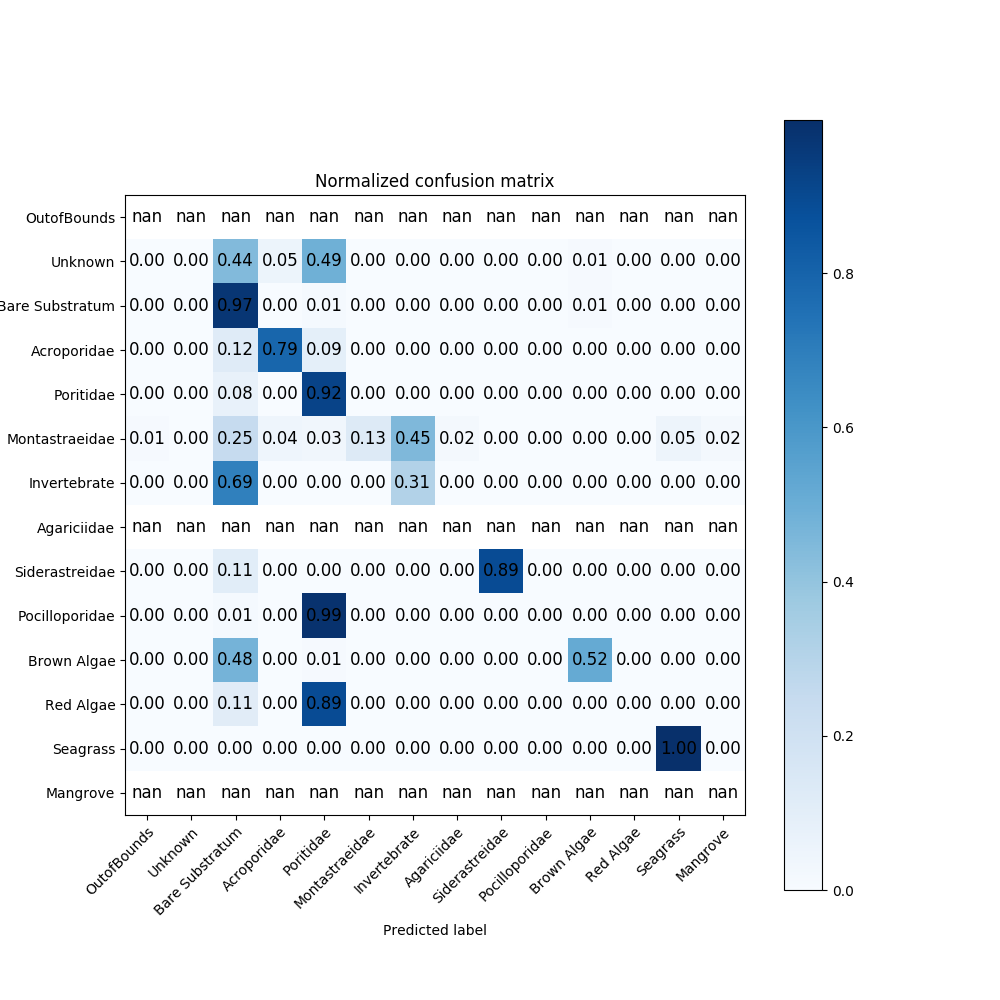

In [83]:
newArr_truth = np.array(img_truthgray_list[0])
newArr_pred = np.array(img_predict_list[0])
for k in range(1,len(img_truthgray_list)):
    newArr_truth = np.append(newArr_truth, img_truthgray_list[k])
    newArr_pred = np.append(newArr_pred, img_predict_list[k])

unique_labels = [list(coralcolors_dict)[int(k)] for k in unique_labels(newArr_truth,newArr_pred)]
plot_confusion_matrix(newArr_truth, newArr_pred, classes=unique_labels, normalize=True, title='Normalized confusion matrix')
